In [476]:
import requests
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from matplotlib import pylab as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pymongo
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

## Model stuff

In [684]:
df = pd.read_csv("mars_weather.csv")
df.drop(["id", "terrestrial_date", "sol", "ls", "month", "wind_speed", "atmo_opacity"], 
        axis=1, inplace=True)
df.head()

,min_temp,max_temp,pressure
0,-77.0,-10.0,727.0
1,-77.0,-10.0,728.0
2,-76.0,-16.0,729.0
3,-77.0,-13.0,729.0
4,-78.0,-18.0,730.0


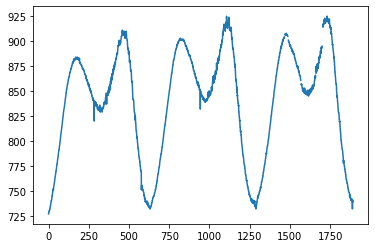

In [314]:
plt.plot(df["pressure"])

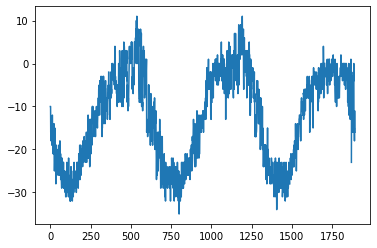

In [315]:
plt.plot(df["max_temp"])

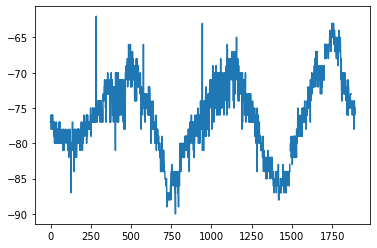

In [316]:
plt.plot(df["min_temp"])

In [81]:
rf_imputer = IterativeImputer(estimator = 
               RandomForestRegressor(max_depth=2, n_estimators=30, n_jobs=-1), 
                               random_state=42)
x_impute = rf_imputer.fit_transform(df)
x_impute = pd.DataFrame(x_impute, columns = df.columns)
x_impute["cos_min_temp"] = np.cos(x_impute["min_temp"])
x_impute["cos_max_temp"] = np.cos(x_impute["max_temp"])
x_impute["cos_pressure"] = np.cos(x_impute["pressure"])
x_impute["sin_min_temp"] = np.sin(x_impute["min_temp"])
x_impute["sin_max_temp"] = np.sin(x_impute["max_temp"])
x_impute["sin_pressure"] = np.sin(x_impute["pressure"])

### Using sin + cos

In [137]:
x_impute_tri = x_impute.drop(["min_temp", "max_temp", "pressure"], axis=1, inplace=False)
model_tri = VAR(x_impute_tri)
results_tri = model_tri.fit(maxlags=7, ic='bic')
lag_order_tri = results_tri.k_ar
lag_order_tri

1

In [138]:
results_tri = model_tri.fit(1)
results_tri.bic

-4.525970777383429

### Using sin

In [118]:
x_impute_sin = x_impute_tri.drop(["cos_min_temp", "cos_max_temp", "cos_pressure"], axis=1, inplace=False)
model_sin = VAR(x_impute_sin)
results_sin = model_sin.fit(maxlags=7, ic='bic')
lag_order_sin = results_sin.k_ar
lag_order_sin

3

In [560]:
results_sin = model_sin.fit(4)
results_sin.bic

-2.265735203456357

### Using cos

In [204]:
x_impute_cos = x_impute_tri.drop(["sin_min_temp", "sin_max_temp", "sin_pressure"], axis=1, inplace=False)
model_cos = VAR(x_impute_cos)
results_cos = model_cos.fit(maxlags=7, ic='bic')
lag_order_cos = results_cos.k_ar
lag_order_cos

2

In [569]:
results_cos = model_cos.fit(2)
results_cos.bic

-2.3227359714276106

### Using original data

In [ ]:
rf_imputer = IterativeImputer(estimator = 
               RandomForestRegressor(max_depth=2, n_estimators=30, n_jobs=-1), 
                               random_state=42)
x_impute = rf_imputer.fit_transform(df)
x_impute = pd.DataFrame(x_impute, columns = df.columns)

In [605]:
x_impute_origin = x_impute
model_origin = VAR(x_impute_origin)
results_origin = model_origin.fit(maxlags=7, ic='bic')
lag_order_origin = results_origin.k_ar
lag_order_origin

6

In [678]:
results_origin = model_origin.fit(6)
results_origin.bic

7.784779178504575

## MongoDB stuff

### Download data

In [666]:
key = "j8jSUUXusA5glsJa3q5bQaDad6sE4H2u9K5rFbST"
requested = requests.get(f"https://api.nasa.gov/insight_weather/?api_key={key}&feedtype=json&ver=1.0").text
requested = json.loads(requested)

In [667]:
main_keys = requested['sol_keys']
print(len(main_keys))
[(requested[key]['First_UTC'], requested[key]['Last_UTC']) for key in main_keys]

7


[('2019-12-05T05:20:37Z', '2019-12-06T06:00:12Z'),
 ('2019-12-06T06:00:13Z', '2019-12-07T06:39:47Z'),
 ('2019-12-07T06:39:48Z', '2019-12-08T00:34:43Z'),
 ('2019-12-08T09:18:29Z', '2019-12-09T07:58:59Z'),
 ('2019-12-09T07:58:59Z', '2019-12-10T08:38:35Z'),
 ('2019-12-10T08:38:36Z', '2019-12-11T09:18:10Z'),
 ('2019-12-11T09:18:11Z', '2019-12-12T09:57:46Z')]

### Write

In [668]:
df_requested = {"sol_day": [], "date": [], "min_temp": [], "max_temp": [], "pressure": [], "wind": []}

for i in main_keys:
    df_requested["sol_day"].append(i)
    df_requested["date"].append(requested[i]['Last_UTC'])
    df_requested["min_temp"].append(requested[i]['AT']["mn"])
    df_requested["max_temp"].append(requested[i]['AT']["mx"])
    df_requested["pressure"].append(requested[i]['PRE']["av"])
    df_requested["wind"].append(requested[i]["WD"])

In [669]:
df_requested = pd.DataFrame(df_requested)
data = df_requested.to_dict(orient='records')

In [670]:
data

[{'sol_day': '364',
  'date': '2019-12-06T06:00:12Z',
  'min_temp': -99.893,
  'max_temp': -20.347,
  'pressure': 663.455,
  'wind': {'0': {'compass_degrees': 0.0,
    'compass_point': 'N',
    'compass_right': 0.0,
    'compass_up': 1.0,
    'ct': 8},
   '1': {'compass_degrees': 22.5,
    'compass_point': 'NNE',
    'compass_right': 0.382683432365,
    'compass_up': 0.923879532511,
    'ct': 42},
   '10': {'compass_degrees': 225.0,
    'compass_point': 'SW',
    'compass_right': -0.707106781187,
    'compass_up': -0.707106781187,
    'ct': 19187},
   '11': {'compass_degrees': 247.5,
    'compass_point': 'WSW',
    'compass_right': -0.923879532511,
    'compass_up': -0.382683432365,
    'ct': 9150},
   '12': {'compass_degrees': 270.0,
    'compass_point': 'W',
    'compass_right': -1.0,
    'compass_up': -0.0,
    'ct': 9256},
   '13': {'compass_degrees': 292.5,
    'compass_point': 'WNW',
    'compass_right': -0.923879532511,
    'compass_up': 0.382683432365,
    'ct': 1436},
   '2': 

In [671]:
client = pymongo.MongoClient('localhost', 27017)
db = client.get_database("MarsWeather")
collection = db.get_collection("DailyWeather")
update_count = 0
for record in data:
    result = collection.replace_one(
        filter={'sol_day': record['sol_day']},    # locate the document if exists
        replacement=record,                         # latest document
        upsert=True)                                # update if exists, insert if not
    if result.matched_count > 0:
        update_count += 1
print(f"rows={df_true.shape[0]}, update={update_count}, "
      f"insert={df_true.shape[0]-update_count}")

rows=7, update=7, insert=0


### Read

In [690]:
df = pd.DataFrame(list(collection.find()))
df

,_id,date,max_temp,min_temp,pressure,sol_day,wind
0,5df3f5f44313285b4fdcc1e3,2019-12-04T04:41:02Z,-21.174,-98.548,665.169,361,"{'1': {'compass_degrees': 22.5, 'compass_point..."
1,5df3f5f44313285b4fdcc1e5,2019-12-05T05:20:37Z,-21.075,-99.804,664.490,362,"{'0': {'compass_degrees': 0.0, 'compass_point'..."
2,5df3f5f44313285b4fdcc1e7,2019-12-06T06:00:12Z,-20.347,-99.893,663.455,363,"{'0': {'compass_degrees': 0.0, 'compass_point'..."
3,5df3f5f44313285b4fdcc1e9,2019-12-06T06:00:12Z,-20.347,-99.893,663.455,364,"{'0': {'compass_degrees': 0.0, 'compass_point'..."
4,5df3f5f44313285b4fdcc1eb,2019-12-07T06:39:47Z,-21.531,-98.800,662.454,365,"{'0': {'compass_degrees': 0.0, 'compass_point'..."
5,5df3f5f44313285b4fdcc1ed,2019-12-08T00:34:43Z,-20.442,-98.941,660.866,366,"{'10': {'compass_degrees': 225.0, 'compass_poi..."
6,5df3f5f44313285b4fdcc1ef,2019-12-09T07:58:59Z,-20.914,-139.936,661.043,367,"{'1': {'compass_degrees': 22.5, 'compass_point..."
7,5df3f5f44313285b4fdcc1f1,2019-12-10T08:38:35Z,-20.919,-100.049,660.436,368,"{'1': {'compass_degrees': 22.5, 'compass_point..."
8,5df3f5f44313285b4fdcc1f3,2019-12-11T09:18:10Z,-21.164,-98.234,661.593,369,"{'1': {'compass_degrees': 22.5, 'compass_point..."
9,5df3f5f44313285b4fdcc1f5,2019-12-12T09:57:46Z,-19.470,-98.970,657.809,370,"{'0': {'compass_degrees': 0.0, 'compass_point'..."


### Predict

In [709]:
pred_num = 5
pred = results_origin.forecast_interval(df.iloc[-6:, 2:5].values, pred_num)
pred

(array([[-26.63521561, -87.54469159, 668.37198939],
        [-29.40975277, -84.16217118, 671.13458072],
        [-30.63023485, -79.84285865, 674.23896315],
        [-31.58052002, -73.34342163, 674.49561859],
        [-32.80741195, -68.93064762, 677.45954804]]),
 array([[-30.04178028, -94.11254096, 652.90669567],
        [-33.02729964, -91.69089614, 651.89227536],
        [-34.32601146, -87.7279269 , 654.00935432],
        [-35.34560064, -81.4624548 , 653.70600107],
        [-36.65571362, -77.33835318, 655.78975677]]),
 array([[-23.22865094, -80.97684222, 683.83728311],
        [-25.79220591, -76.63344622, 690.37688607],
        [-26.93445824, -71.9577904 , 694.46857198],
        [-27.8154394 , -65.22438846, 695.2852361 ],
        [-28.95911027, -60.52294205, 699.12933932]]))

## Plot

In [710]:
sol_days_pred = [int(main_keys[-1]) + i for i in range(0, pred_num + 1)]    # Sol days to predict

### Temperature

In [711]:
prev_max_temp = list(df["max_temp"])    # Previous max temperatures
max_temp_dic = {}    # Record predicted max temperature and confidence intervals
for i in range(0, 3):
    max_temp_dic['temp_exp'] = [prev_max_temp[-1]] + [i[0] for i in pred[0]]
    max_temp_dic['temp_lower'] = [prev_max_temp[-1]] +  [i[0] for i in pred[1]]
    max_temp_dic['temp_upper'] = [prev_max_temp[-1]] +  [i[0] for i in pred[2]]

In [712]:
fig = go.Figure()
# plot max temperature
fig.add_trace(go.Scatter(x=df['sol_day'], y=prev_max_temp,
                     mode='lines', 
                     name='Known Max Temperature', 
                     line_color='rgb(255, 102, 163)',
                     showlegend=False))
fig.add_trace(go.Scatter(x=sol_days_pred, y=max_temp_dic['temp_exp'],
                     mode='lines', 
                     line=dict(dash='dash'), 
                     line_color='rgb(255, 102, 163)', 
                     name='Expected Max Temperature'))
fig.add_trace(go.Scatter(x=sol_days_pred, y=max_temp_dic['temp_upper'],
                     mode='lines',
                     name='Interval of Max Temperature', 
                     line_color='rgb(255, 102, 163)', 
                     showlegend=False))
fig.add_trace(go.Scatter(x=sol_days_pred, y=max_temp_dic['temp_lower'],
                     mode='lines',
                     name='Interval of Max Temperature', 
                     fill='tonexty', 
                     line_color='rgb(255, 102, 163)', 
                     fillcolor='rgba(255, 102, 163, 0.5)'))
fig.show()

In [713]:
prev_min_temp = list(df["min_temp"])    # Previous max temperatures
min_temp_dic = {}    # Record predicted max temperature and confidence intervals
for i in range(0, 3):
    min_temp_dic['temp_exp'] = [prev_min_temp[-1]] + [i[1] for i in pred[0]]
    min_temp_dic['temp_lower'] = [prev_min_temp[-1]] +  [i[1] for i in pred[1]]
    min_temp_dic['temp_upper'] = [prev_min_temp[-1]] +  [i[1] for i in pred[2]]

In [714]:
fig = go.Figure()
# plot min temperature
fig.add_trace(go.Scatter(x=df['sol_day'], y=prev_min_temp,
                     mode='lines', 
                     name='Known Max Temperature', 
                     line_color='rgb(102, 181, 255)',
                     showlegend=False))
fig.add_trace(go.Scatter(x=sol_days_pred, y=min_temp_dic['temp_exp'],
                     mode='lines', 
                     line=dict(dash='dash'), 
                     line_color='rgb(102, 181, 255)', 
                     name='Expected Min Temperature'))
fig.add_trace(go.Scatter(x=sol_days_pred, y=min_temp_dic['temp_upper'],
                     mode='lines',
                     name='Interval of Min Temperature', 
                     line_color='rgb(102, 181, 255)', 
                     showlegend=False))
fig.add_trace(go.Scatter(x=sol_days_pred, y=min_temp_dic['temp_lower'],
                     mode='lines',
                     name='Interval of Min Temperature', 
                     fill='tonexty', 
                     line_color='rgb(102, 181, 255)', 
                     fillcolor='rgba(102, 181, 255, 0.5)'))
fig.show()

### Pressure

In [715]:
prev_ps = list(df['pressure'])    # Previous max temperatures
ps_dic = {}    # Record predicted max temperature and confidence intervals
for i in range(0, 3):
    ps_dic['ps_exp'] = [prev_ps[-1]] + [i[2] for i in pred[0]]
    ps_dic['ps_lower'] = [prev_ps[-1]] +  [i[2] for i in pred[1]]
    ps_dic['ps_upper'] = [prev_ps[-1]] +  [i[2] for i in pred[2]]

In [716]:
fig = go.Figure()
# plot avg pressure
fig.add_trace(go.Scatter(x=df['sol_day'], y=prev_ps,
                     mode='lines', 
                     name='Known Avg Pressure', 
                     line_color='rgb(102, 255, 179)',
                     showlegend=False))
fig.add_trace(go.Scatter(x=sol_days_pred, y=ps_dic['ps_exp'],
                     mode='lines', 
                     line=dict(dash='dash'), 
                     line_color='rgb(102, 255, 179)', 
                     name='Avg Pressure'))
fig.add_trace(go.Scatter(x=sol_days_pred, y=ps_dic['ps_upper'],
                     mode='lines',
                     name='Interval of Avg Pressure', 
                     line_color='rgb(102, 255, 179)', 
                     showlegend=False))
fig.add_trace(go.Scatter(x=sol_days_pred, y=ps_dic['ps_lower'],
                     mode='lines',
                     name='Interval of Avg Pressure', 
                     fill='tonexty', 
                     line_color='rgb(102, 255, 179)', 
                     fillcolor='rgba(102, 255, 179, 0.5)'))
fig.show()

### Wind

In [728]:
main_keys

['364', '365', '366', '367', '368', '369', '370']

In [753]:
day = '370'
df_wind = pd.DataFrame.from_dict(df["wind"][df["sol_day"] == day].iloc[0], orient='index')
df_wind

,compass_degrees,compass_point,compass_right,compass_up,ct
0,0.0,N,0.000000,1.000000,4
1,22.5,NNE,0.382683,0.923880,2
10,225.0,SW,-0.707107,-0.707107,28892
11,247.5,WSW,-0.923880,-0.382683,9754
12,270.0,W,-1.000000,-0.000000,6898
13,292.5,WNW,-0.923880,0.382683,754
14,315.0,NW,-0.707107,0.707107,432
15,337.5,NNW,-0.382683,0.923880,66
3,67.5,ENE,0.923880,0.382683,689
5,112.5,ESE,0.923880,-0.382683,602


In [751]:
wind.head()

,direction,strength,frequency
0,N,0-1,0.5
1,NNE,0-1,0.6
2,NE,0-1,0.5
3,ENE,0-1,0.4
4,E,0-1,0.4


In [766]:
requested['364']['HWS']

{'av': 5.259, 'ct': 154422, 'mn': 0.188, 'mx': 21.69}

In [763]:
wind = px.data.wind()
fig = px.bar_polar(wind, r="frequency", theta="direction",
                   color="strength", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma[-2::-1])
fig.show()